<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/ppf_bis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Model for Drug Effect Prediction
In this example, we will build a model to predict bispectral index value during the anesthesia using propofol and remifentanil.

## Required libraries

In [1]:
!pip install vitaldb

import vitaldb
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 1.1 MB 39.6 MB/s 
     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 140 kB 6.9 MB/s 
     |████████████████████████████████| 8.6 MB 47.4 MB/s 
     |████████████████████████████████| 144 kB 55.1 MB/s 
     |████████████████████████████████| 94 kB 4.8 MB/s 
     |████████████████████████████████| 271 kB 59.6 MB/s 
     |████████████████████████████████| 127 kB 60.8 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-2.3.3-py3-none-any.whl size=64640 sha256=3eae85cbd8590f4a28a2e3dc8c4ee65158bbff30eb3cca43a7d2251ad1fbfbcc
  Stored in directory: /root/.cache/pip/wheels/71/90/2f/bf0c130857587a589d0faa0fb743a7e52b915037532008aabe
Successfully built aiobotocore
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Unin

## Case selection

Load data using the VitalDB Open Dataset API endpoints.


In [2]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")
df_cases['sex'] = (df_cases['sex'] == 'F').astype(int)  # female: 1, male: 0

Inclusion, exclusion criteria
* More than 2 hours
* General anesthesia
* Age >= 18
* PPF20_VOL, RFTN20_VOL, PPF20_CE, RFTN20_CE, BIS tracks should exist
* Weight > 35 kg

In [9]:
caseids = list(
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_VOL', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN20_VOL', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_CE', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN20_CE', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid']) & 
  set(df_cases.loc[df_cases['age'] > 18, 'caseid']) & 
  set(df_cases.loc[df_cases['weight'] > 35, 'caseid']) &
  set(df_cases.loc[df_cases['caseend'] > 7200, 'caseid']) &
  set(df_cases.loc[df_cases['ane_type'] == 'General', 'caseid'])
  )
np.random.shuffle(caseids)
len(caseids)

2225

## Preprocessing
* Set a variable to save the dataset
* Read BIS and the infusion rates of propofol and remifentanil
* Skip the cases where the recorded data is short, there was no drug infusion, and the bis value is not appropriate.
* Preprocess missing values and negative numbers

In [4]:
x_ppf_dose = []  # Propofol dose of each record
x_rft_dose = []  # Remifentanil dose of each record
x_aswh = []  # Age, gender, height, weight of each record
c = []  # Caseid of each record
y = []  # Output of each record (bis)
y_old = []  # Predicted value of classical model

LSTM_TIMEPOINTS = 180  # 180 timpoints x 10 sec/timepoints = 1800 sec
LSTM_NODES = 8
FNN_NODES = 16
BATCH_SIZE = 256  # Number of records to process at one time
MAX_CASES = 50  # Maximum number of cases to use in this example

# for each caseid
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # Column order when loading data
    PPF_DOSE = 0
    RFT_DOSE = 1
    PPF_CE = 2
    RFT_CE = 3
    BIS = 4

    # Extract data every 10 seconds
    vals = vitaldb.load_case(caseid, ['Orchestra/PPF20_VOL', 'Orchestra/RFTN20_VOL', 'Orchestra/PPF20_CE', 'Orchestra/RFTN20_CE', 'BIS/BIS'], 10)

    # Replace missing values with the last value measured
    vals = pd.DataFrame(vals).fillna(method='ffill').values
    vals = np.nan_to_num(vals, 0)  # Replace missing values at beginning with 0

    # Excluding cases where drug injection was not performed or cases where bis was not used
    if (np.max(vals, axis=0) <= 1).any():
        print('no drug infusion or bis')
        continue

    # Get the drug infusion start time and delete the previous one
    first_ppf_idx = np.where(vals[:, PPF_DOSE] > 1)[0][0]
    first_rft_idx = np.where(vals[:, RFT_DOSE] > 1)[0][0]
    first_drug_idx = min(first_ppf_idx, first_rft_idx)
    vals = vals[first_drug_idx:, :]

    # Change volume to rate
    vals[1:, PPF_DOSE] -= vals[:-1, PPF_DOSE]
    vals[1:, RFT_DOSE] -= vals[:-1, RFT_DOSE]
    vals[0, PPF_DOSE] = 0
    vals[0, RFT_DOSE] = 0

    # Replace negative values (decrease in volume) with 0
    vals[vals < 0] = 0

    # 1) Excluding cases where the first value of bis is less than or equal to 80
    # 2) Excluding cases where the last value is less than or equal to 70
    valid_bis_idx = np.where(vals[:, BIS] > 0)[0]
    first_bis_idx = valid_bis_idx[0]
    last_bis_idx = valid_bis_idx[-1]
    if vals[first_bis_idx, BIS] < 80:
        print('first bis < 80')
        continue
    if vals[last_bis_idx, BIS] < 70:
        print('last bis < 70')
        continue

    # Set both dose and bis during LSTM_TIMEPOINTS before infusion to 0 
    vals = np.vstack((np.zeros((LSTM_TIMEPOINTS - 1, vals.shape[1])), vals))

    # Get the current case's age, gender, height, and weight
    aswh = df_cases.loc[df_cases['caseid'] == caseid, ['age','sex','weight','height']].values.astype(float).flatten()

    # Append the bis from the beginning to the end into the dataset
    for irow in range(1, vals.shape[0] - LSTM_TIMEPOINTS - 1):
        bis = vals[irow + LSTM_TIMEPOINTS, BIS]
        if bis == 0:
            continue

        # Append input values into dataset
        x_ppf_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, PPF_DOSE])
        x_rft_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, RFT_DOSE])

        x_aswh.append(aswh)
        c.append(caseid)
        y.append(bis)

        ppf_ce = vals[irow + LSTM_TIMEPOINTS, PPF_CE]
        rft_ce = vals[irow + LSTM_TIMEPOINTS, RFT_CE]
        
        ug = (ppf_ce / 4.47 + rft_ce / 19.3)**1.43

        y_old.append(98 - (98 - 0) * (ug / (1 + ug)))

    print('done')
    if len(np.unique(c)) >= MAX_CASES:
        break


loading 1118...first bis < 80
loading 5271...done
loading 4032...done
loading 4181...first bis < 80
loading 4478...done
loading 5642...done
loading 2733...done
loading 6053...done
loading 3043...first bis < 80
loading 1190...done
loading 744...done
loading 4966...done
loading 6358...last bis < 70
loading 6302...done
loading 5983...first bis < 80
loading 2707...first bis < 80
loading 3976...done
loading 1527...first bis < 80
loading 2716...done
loading 2381...done
loading 4341...done
loading 4694...first bis < 80
loading 569...last bis < 70
loading 2593...done
loading 5309...done
loading 3710...done
loading 6275...done
loading 1215...done
loading 2933...done
loading 5634...done
loading 5810...first bis < 80
loading 136...done
loading 104...done
loading 1749...first bis < 80
loading 301...done
loading 1947...done
loading 6160...last bis < 70
loading 832...done
loading 5382...done
loading 474...done
loading 5781...first bis < 80
loading 2906...done
loading 1157...last bis < 70
loading 305

### Converting format

In [5]:
# Convert the input dataset to a numpy array
x_ppf_dose = np.array(x_ppf_dose)[..., None]  # Add the last dimension since it should be 3D to be used in the LSTM
x_rft_dose = np.array(x_rft_dose)[..., None]
x_aswh = np.array(x_aswh)
y = np.array(y) / 100  # normalization
y_old = np.array(y_old) / 100
c = np.array(c)

# final caseids loaded
caseids = np.unique(c)

# normalize data
x_aswh = (x_aswh - np.mean(x_aswh, axis=0)) / np.std(x_aswh, axis=0)

###Split samples into training and testing dataset

In [6]:
# split cases
ncase = len(caseids)
ntest = int(ncase * 0.1)
ntrain = ncase - ntest
train_caseids = caseids[:ntrain]
test_caseids = caseids[ntrain:ncase]

# making masks
train_mask = np.isin(c, train_caseids)
test_mask = np.isin(c, test_caseids)

# split samples
x_train = [x_ppf_dose[train_mask], x_rft_dose[train_mask], x_aswh[train_mask]]
y_train = y[train_mask]
x_test = [x_ppf_dose[test_mask], x_rft_dose[test_mask], x_aswh[test_mask]]
y_test = y[test_mask]
y_test_old = y_old[test_mask]

print('train: {} cases {} samples, testing: {} cases {} samples'.format(len(train_caseids), np.sum(train_mask), len(test_caseids), np.sum(test_mask)))

train: 45 cases 62572 samples, testing: 5 cases 7478 samples


## Model building


In [7]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, concatenate
from keras.callbacks import EarlyStopping
import tensorflow as tf

input_cov = Input(batch_shape=(None, 4))
input_ppf = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
input_rft = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
output_ppf = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_ppf)
output_rft = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_rft)
output = concatenate([output_ppf, output_rft, input_cov])
output = Dense(FNN_NODES)(output)
output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(output)

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()

model = Model(inputs=[input_ppf, input_rft, input_cov], outputs=[output])
model.compile(loss=mae, optimizer='adam', metrics=[mape])
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=100, steps_per_epoch=100,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')])

Epoch 1/100
100/100 [==============================] - 12s 36ms/step - loss: 0.1161 - mean_absolute_percentage_error: 27.3707 - val_loss: 0.0761 - val_mean_absolute_percentage_error: 17.3960
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.0962 - mean_absolute_percentage_error: 22.4483 - val_loss: 0.0734 - val_mean_absolute_percentage_error: 16.9081
Epoch 3/100
100/100 [==============================] - 3s 34ms/step - loss: 0.0892 - mean_absolute_percentage_error: 20.6896 - val_loss: 0.0721 - val_mean_absolute_percentage_error: 16.4516
Epoch 4/100
100/100 [==============================] - 4s 37ms/step - loss: 0.0846 - mean_absolute_percentage_error: 19.6068 - val_loss: 0.0707 - val_mean_absolute_percentage_error: 17.1053
Epoch 5/100
100/100 [==============================] - 3s 35ms/step - loss: 0.0812 - mean_absolute_percentage_error: 18.8546 - val_loss: 0.0729 - val_mean_absolute_percentage_error: 16.3902
Epoch 6/100
100/100 [============================

## Prediction

Test MAPE (LSTM): 16.0%
Test MAPE (Short): 22.3%

CaseID 5998, LSTM MAPE=7.827597141265869, Short MAPE=17.066808700561523


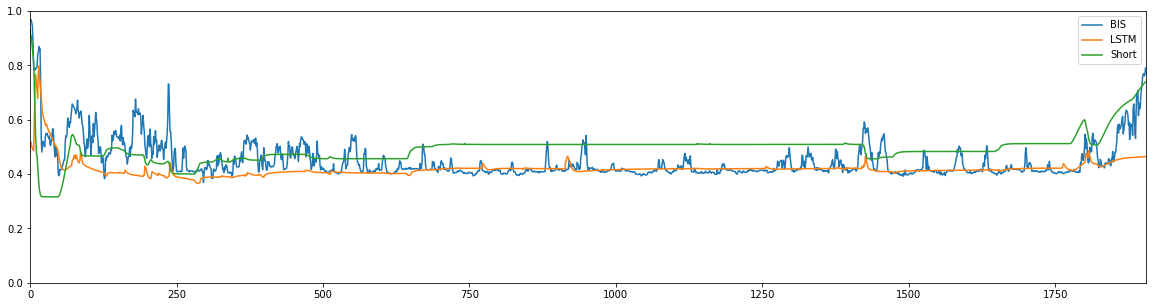

CaseID 6053, LSTM MAPE=13.782140731811523, Short MAPE=17.433815002441406


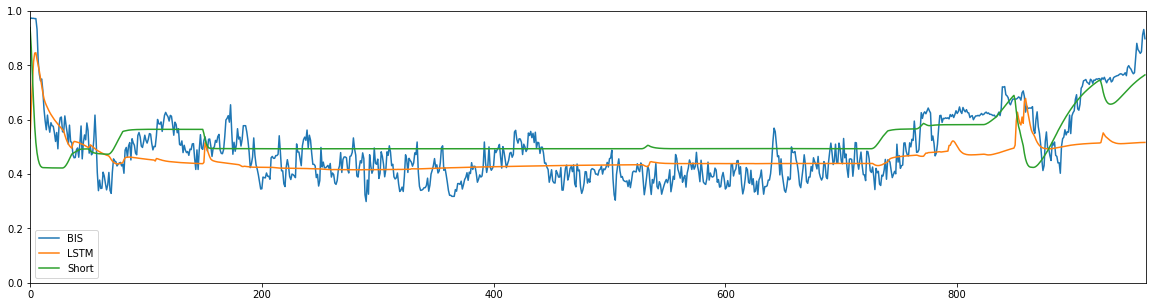

CaseID 6124, LSTM MAPE=27.598485946655273, Short MAPE=62.90340805053711


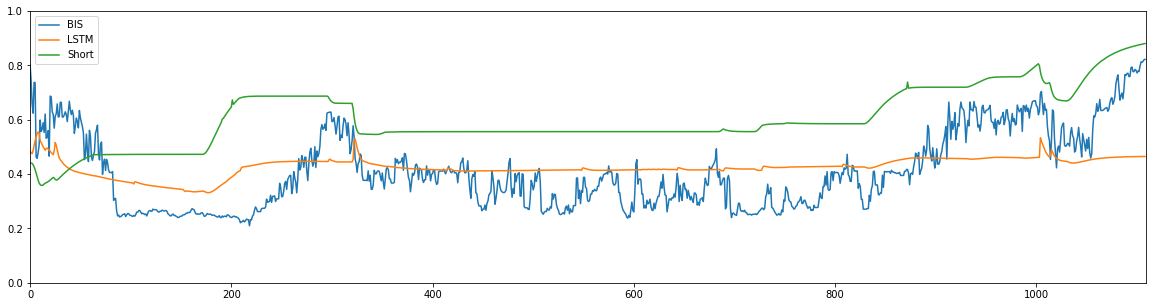

CaseID 6275, LSTM MAPE=18.102678298950195, Short MAPE=26.69438934326172


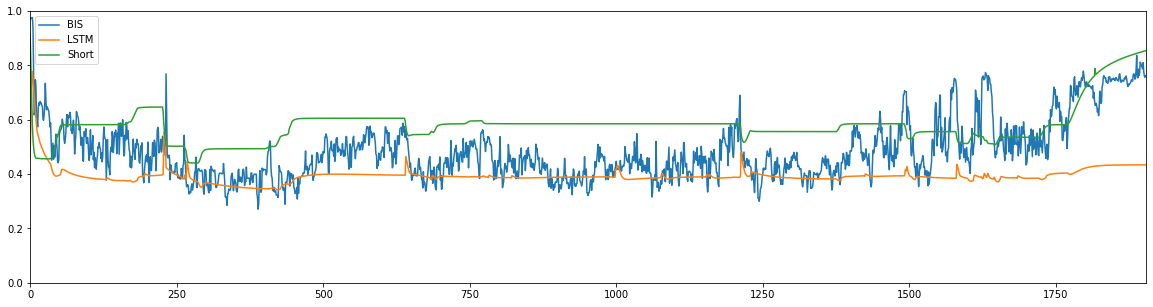

CaseID 6302, LSTM MAPE=16.64453125, Short MAPE=28.782413482666016


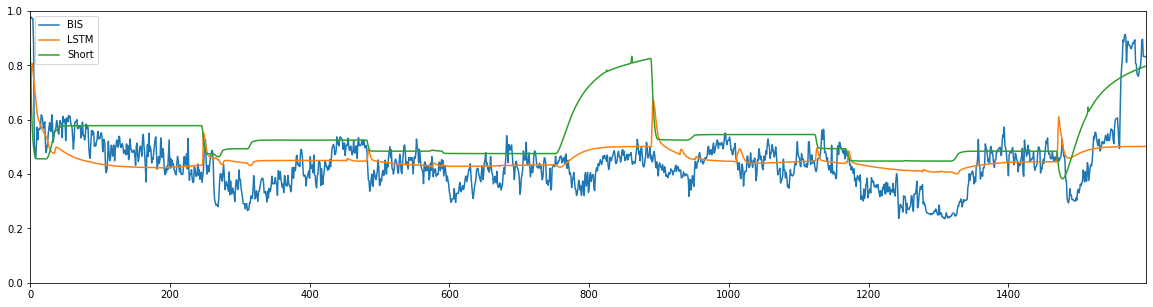

In [8]:
# Prediction
y_pred = model.predict(x_test).flatten()
print(f"Test MAPE (LSTM): {mape(y_test, y_pred):.1f}%")
print(f"Test MAPE (Short): {mape(y_test_old, y_pred):.1f}%")
print()

# Plotting
import matplotlib.pyplot as plt
for caseid in test_caseids:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    print('CaseID {}, LSTM MAPE={}, Short MAPE={}'.format(caseid, 
      mape(y_test[case_mask], y_pred[case_mask]), 
      mape(y_test[case_mask], y_test_old[case_mask])
      ))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='BIS')  # Ground truth
    plt.plot(t, y_pred[case_mask], label='LSTM')  # LSTM model
    plt.plot(t, y_test_old[case_mask], label='Short')  # Short model
    plt.legend()
    plt.xlim([0, case_len])
    plt.ylim([0, 1])
    plt.show()